# Imports and helper variables

In [1]:
import os

import numpy as np
import phoebe
from phoebe import u
phoebe.atmospheres.passbands._url_tables_server = 'https://staging.phoebe-project.org'

import tqdm
import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")

from astropy.table import Table
from astropy.time import Time
from astropy.timeseries import TimeSeries
from astropy.coordinates import EarthLocation, SkyCoord

import utils as gen_utils
from optimizers import opt_utils, dc_optimizer

import importlib
importlib.reload(gen_utils)
importlib.reload(opt_utils)
importlib.reload(dc_optimizer)

logger = phoebe.logger(clevel='WARNING')

CLEAN_ITURBIDE_PATH = "/home/ramon/uanl/thesis/Backup Data/Iturbide/cleaned-iturbide.ecsv"
CLEAN_ZTF_PATH = "/home/ramon/uanl/thesis/Backup Data/IRSA/cleaned-ztf-flux.ecsv"

# ORBITAL_PERIOD = 0.3335614 *u.day # from periodogram notebook
# ORBITAL_PERIOD = 0.3335669516750462 * u.day # from periodogram notebook

ITURBIDE_LOCATION = EarthLocation(lon=-99.895328*u.deg, lat=24.75521 * u.deg, height=2400*u.m)
ATO_COORD = SkyCoord.from_name("ATO J339.9469+45.1464")

PHOEBE: passband "Bolometric:900-40000" has a newer version available.  Run phoebe.list_passband_online_history("Bolometric:900-40000") to get a list of available changes and phoebe.update_passband("Bolometric:900-40000") or phoebe.update_all_passbands() to update.
PHOEBE: passband "Johnson:V" has a newer version available.  Run phoebe.list_passband_online_history("Johnson:V") to get a list of available changes and phoebe.update_passband("Johnson:V") or phoebe.update_all_passbands() to update.


In [2]:
ztfDatasetsPassbands = {
    'lcZtfR': 'ZTF:r',
    'lcZtfG': 'ZTF:g'
}

ztfDatasets = ['lcZtfR', 'lcZtfG']
iturbideDataset = 'lcIturbide'
allDatasets = ztfDatasets + [iturbideDataset]

# Load data

In [3]:
ztfData = Table.read(CLEAN_ZTF_PATH)
ztfData

time,mag,err,filter,hjd,ltt_corr,magzp,norm_flux,norm_ferr,flux,ferr
,mag,mag,,,,mag,,mag,,mag
TimeDelta,float64,float64,str5,Time,TimeDelta,float64,float64,float64,float64,float64
-0.16635495227284516,17.4029655,0.0183366165,ZTF:g,2459855.823404422,--,26.3760471,1.0748268824054272,0.018152372795700807,3883.58343514,65.58847331783878
-0.16571271684552666,17.3737259,0.0181318633,ZTF:g,2459171.6813231735,--,26.2424183,1.1041659745512657,0.018439641621359425,3527.58071756,58.91082112787078
-0.1639303101681793,17.347332,0.0179516952,ZTF:g,2459059.938682193,--,26.4026089,1.1313368155295236,0.018705661275658557,4189.00385473,69.26150206852135
-0.16235914135922513,17.3862724,0.0182190519,ZTF:g,2459853.8260075753,--,26.4263515,1.0914799441631682,0.018315433954740255,4130.77595163,69.31593615489366
-0.16127007469252327,17.3823967,0.0181920044,ZTF:g,2459153.6732318965,--,26.4453449,1.0953831096376578,0.018353642683079867,4218.70618825,70.6863427806577
-0.16126194233193403,17.3224964,0.0177861098,ZTF:g,2459402.84662591,--,26.3122578,1.1575137535579465,0.01896194179172473,3943.70626167,64.60426785222208
-0.16061481399763297,17.358345,0.018026337,ZTF:g,2459068.9482646487,--,26.429224,1.1199192766000492,0.018593874096043437,4249.63470433,70.55613230116217
-0.16010243389899706,17.2687778,0.0174406506,ZTF:g,2458388.80883886,--,26.3095112,1.2162240862985692,0.01953673392070678,4133.26604199,66.39444144841066


In [4]:
iturbideData = Table.read(CLEAN_ITURBIDE_PATH)
iturbideData.remove_column('time')
iturbideData.rename_column('hjd', 'time')
iturbideData

mag,err,filter,time,ltt_corr,obsv_date,norm_flux,norm_ferr
mag,mag,,,,,,mag
float64,float64,str18,Time,TimeDelta,str10,float64,float64
1.2027999999999999,0.0206155281280883,Iturbide:Luminance,2459880.841608384,0.0033265544398984777,2022-10-28,1.2238269144863219,0.023237539716311435
1.3013000000000012,0.03956008088970497,Iturbide:Luminance,2459922.5373161673,0.0012063471745832476,2022-12-09,1.11768648628847,0.04072422713098342
1.2391000000000005,0.0206155281280883,Iturbide:Luminance,2459880.842311,0.003326530177332098,2022-10-28,1.1835864919618604,0.022473470544809505
1.2182999999999993,0.0206155281280883,Iturbide:Luminance,2459924.539855498,0.0010780078240699316,2022-12-11,1.2064796473587158,0.022908156693209343
1.2197999999999993,0.0206155281280883,Iturbide:Luminance,2459880.843009906,0.003326506041772801,2022-10-28,1.2048139849918464,0.02287652975728733
1.1997999999999998,0.01969771560359221,Iturbide:Luminance,2459924.540559342,0.0010779623057632398,2022-12-11,1.2272131493198564,0.02226442803910769
1.251100000000001,0.022472205054244233,Iturbide:Luminance,2459880.8437087024,0.0033264819089261146,2022-10-28,1.170577035963137,0.024228212220124983
1.2329000000000008,0.01969771560359221,Iturbide:Luminance,2459924.5412554373,0.0010779172855032103,2022-12-11,1.19036459177042,0.021595911686949115


In [5]:
ORBITAL_PERIOD = ztfData.meta['period'] * u.day
ORBITAL_PERIOD

<Quantity 0.33356544 d>

## Phased graphs

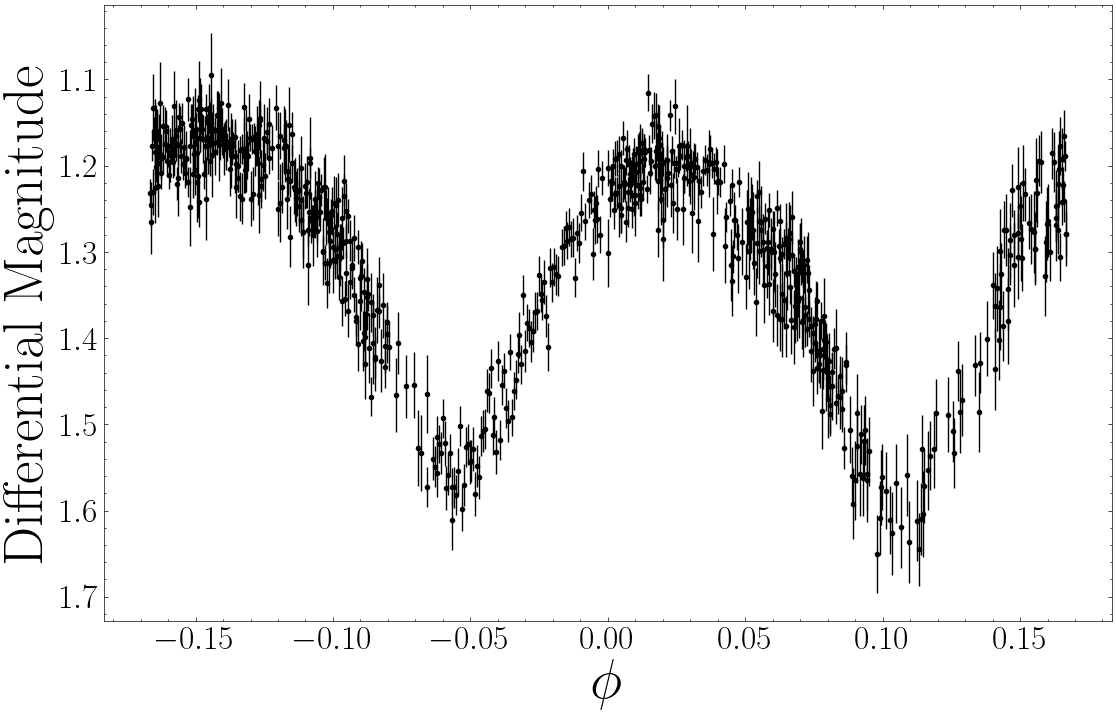

In [6]:
iturbideTs = TimeSeries(iturbideData).fold(ORBITAL_PERIOD)
plt.figure(figsize=(13, 8))
plt.errorbar(iturbideTs.time.value, iturbideTs['mag'], iturbideTs['err'], linestyle='none', marker='.', color='black')
plt.gca().invert_yaxis()
plt.tick_params(axis='both', labelsize=24)
plt.xlabel(r"$\phi$", fontsize=40)
plt.ylabel("Differential Magnitude", fontsize=40)
plt.show()

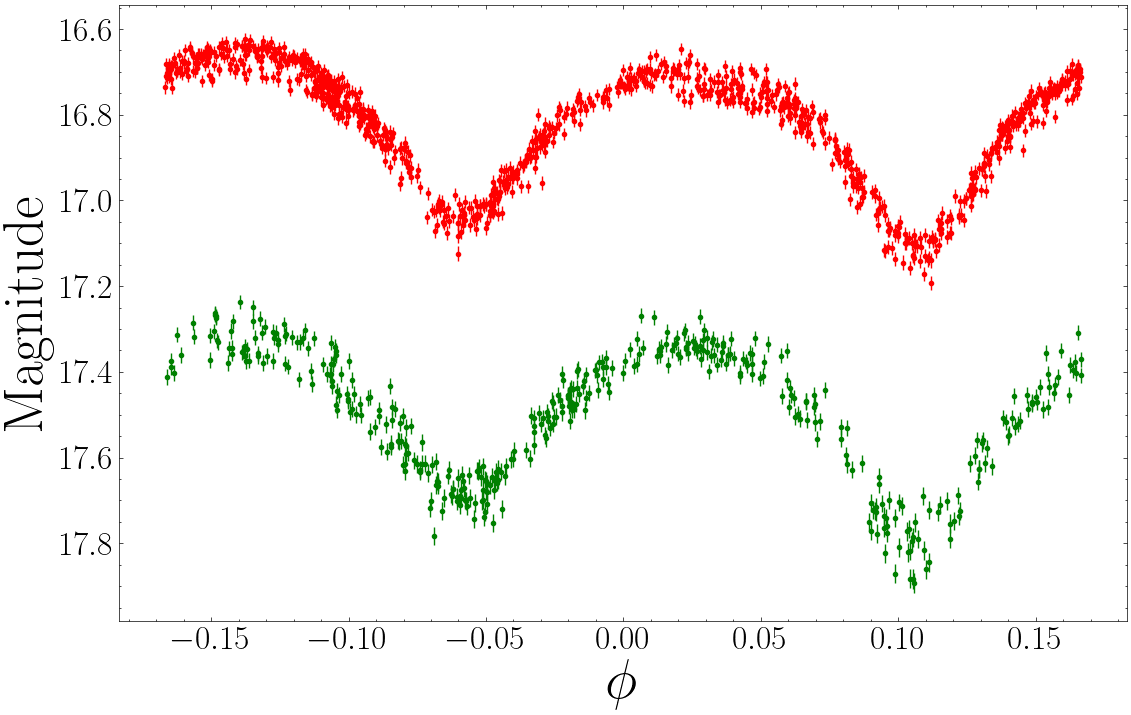

In [7]:
ztfTs = TimeSeries(ztfData).fold(ORBITAL_PERIOD)
plt.figure(figsize=(13, 8))
for pb, color in zip(['ZTF:g', 'ZTF:r'], ['g', 'r']):
    bandTs = ztfTs[ztfTs['filter'] == pb]
    plt.errorbar(bandTs.time.value, bandTs['mag'], bandTs['err'], linestyle='none', marker='.', color=color)
plt.gca().invert_yaxis()
plt.tick_params(axis='both', labelsize=24)
plt.xlabel(r"$\phi$", fontsize=40)
plt.ylabel("Magnitude", fontsize=40)
plt.show()

# Model setup

In [8]:
b = phoebe.default_contact_binary()
b.set_value(qualifier='period', component='binary', value=ORBITAL_PERIOD)

# remove constraints for q-search
b.flip_constraint('pot', solve_for='requiv@primary')
b.flip_constraint('fillout_factor', solve_for='pot')
b.flip_constraint('teffratio', solve_for='teff@secondary')

b.add_dataset('mesh', dataset='mesh01', compute_phases=phoebe.linspace(0, 1, 21), columns=['teffs'])

# fixed primary teff, value taken from teff_msc1 value from GDR3 astrophysical params table
b.set_value(qualifier='teff', component='primary', value=5206.8496*u.K)

b.set_value_all(qualifier='irrad_frac_refl_bol', value=0.5)

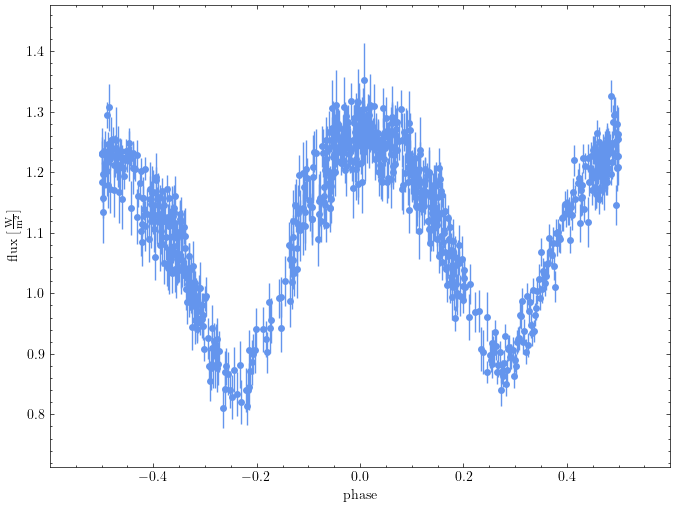

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [9]:
# Iturbide images seem to have their time at end of exposure
    # need this to be at half of exposure
HALF_EXPOSURE = 30 * u.second
iturbideHjd = iturbideData['time']
iturbideHjd -= (HALF_EXPOSURE.to(u.day))
# iturbideHjd += 1*u.hour
# iturbideHjd = iturbideHjd + iturbideHjd.light_travel_time(skycoord=ATO_COORD, kind='heliocentric', location=ITURBIDE_LOCATION)

# loading Iturbide data; Luminance filter seems to be very similar to Gaia:BP
b.add_dataset('lc', times=iturbideHjd.value, fluxes=iturbideData['norm_flux'], sigmas=iturbideData['norm_ferr'].data, 
                    dataset=iturbideDataset, passband='Gaia:BP', pblum_mode='dataset-scaled', exptime=60*u.second, 
                    # fti_method='oversample',
                    overwrite=True)
b.plot(dataset=iturbideDataset, x='phase', show=True, c=gen_utils.ITURBIDE_PLOT_COLORS, s=0.008)

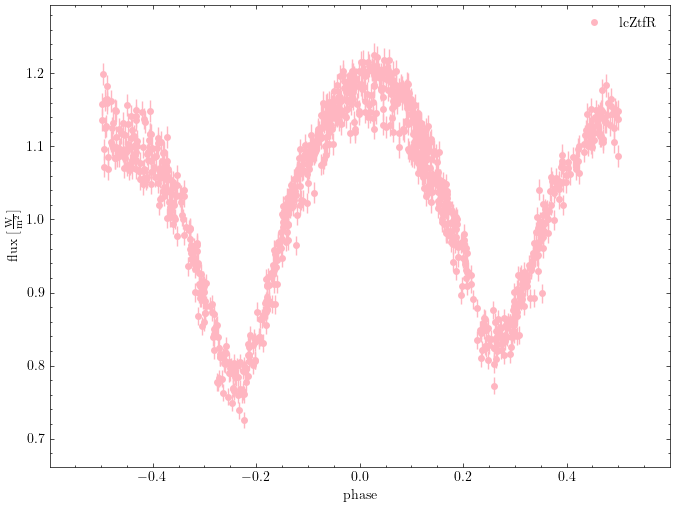

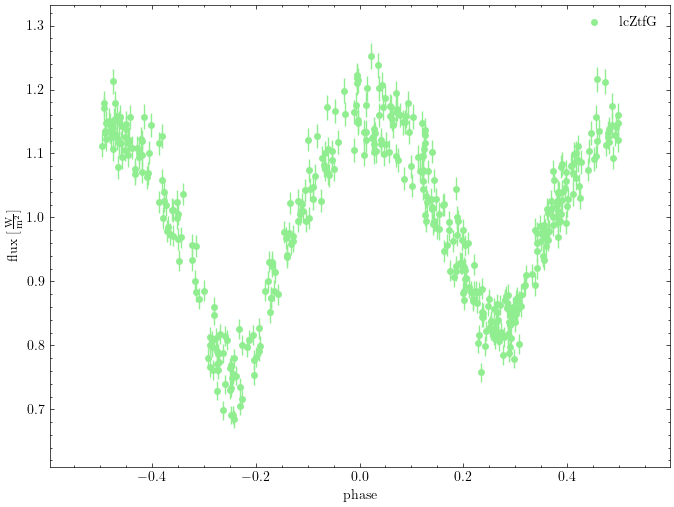

In [10]:
# ztf data
for d, band in ztfDatasetsPassbands.items():
    bandData = ztfData[ztfData['filter'] == band]
    b.add_dataset('lc', times=bandData['hjd'].value, fluxes=bandData['norm_flux'], sigmas=bandData['norm_ferr'].data, dataset=d, passband=band, pblum_mode='dataset-scaled', overwrite=True)
    b.plot(x='phase', show=True, dataset=d, s=0.008, c=gen_utils.ZTF_PLOT_COLORS, legend=True)

# Compute phase adjustment

Reduce forward model compute time.

In [11]:
b.flip_constraints_all(qualifier='compute_phases', solve_for='compute_times')

In [12]:
b.set_value_all(qualifier='compute_phases', dataset=allDatasets, value=phoebe.linspace(0, 1, 101))

# `t0_supconj`

Determining `t0` so that model is in phase. Doing so before any parameter estimation/optimization in order to use *q-search* algorithm.

In [13]:
opt_utils.optimize_params(b, fit_twigs=['t0_supconj'], label='t0_init', export=False, datasets=allDatasets, maxiter=100)

 47%|████▋     | 47/100 [07:31<08:29,  9.62s/it]


('opt_t0_init', 'opt_t0_init_solution')

Adopted:
t0_supconj@binary@orbit@component -0.08045 d 

Original values:
  t0_supconj@binary@orbit@component 0.00000 d 


100%|██████████| 105/105 [00:04<00:00, 21.37it/s]


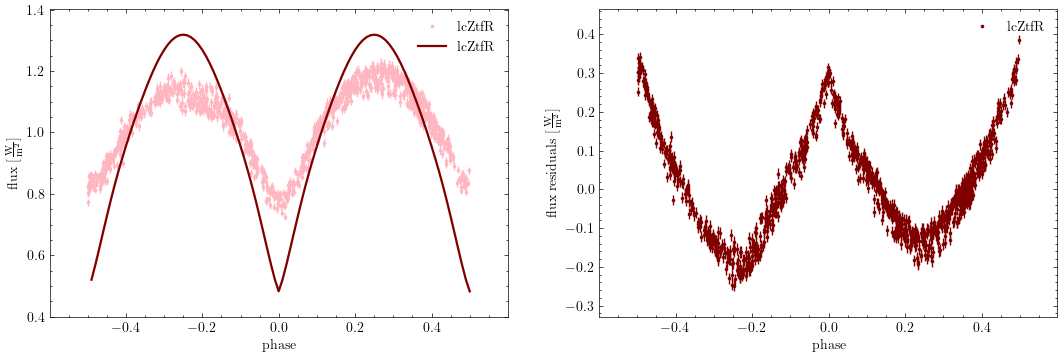

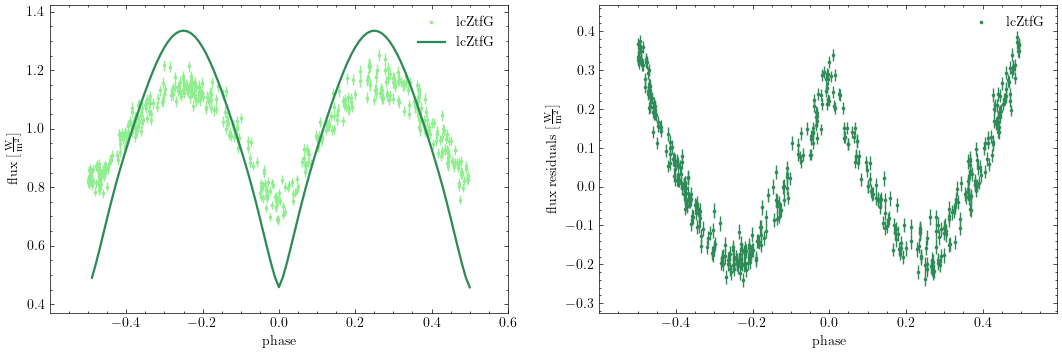

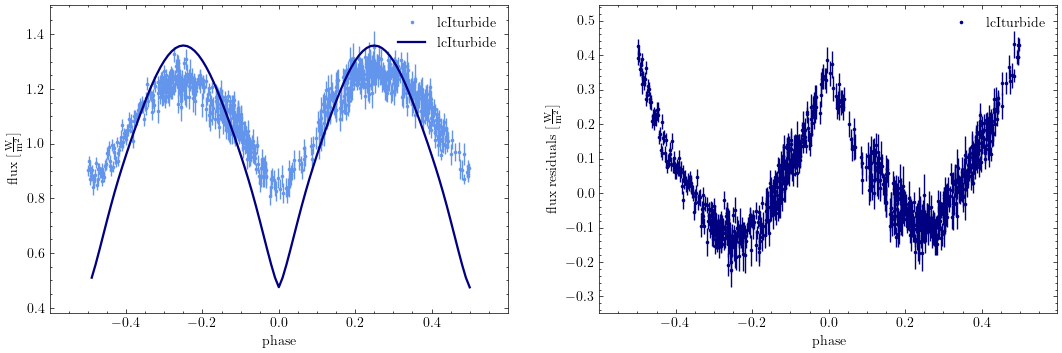

In [14]:
_, computeModelName = opt_utils.adopt_solution(b, solution_name='opt_t0_init_solution')
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 4), datasetGroups=allDatasets, model=computeModelName)

In [15]:
b.remove_models_all()
gen_utils.saveBundle(b, "t0-default", subfolder="q-search")

Fri, 28 Feb 2025 14:31 PARAMETERS   WARNING for faster compact saving, install ujson


'bundle-saves/q-search/t0-default.json.gz'

# q-search results

## Fixed `q` only

In [3]:
b = gen_utils.loadBundle("t0-default", subfolder="q-search")

In [73]:
solutionVals = {}

for sfile in tqdm.tqdm(os.listdir("q-solutions/")):
    b.import_solution(os.path.join("q-solutions", sfile), overwrite=True)
    for t, val in zip(b.get_value(qualifier='fitted_twigs', solution='opt_q_search_solution'), b.get_value(qualifier='fitted_values', solution='opt_q_search_solution')):
        if t not in solutionVals.keys():
            solutionVals[t] = []
        solutionVals[t].append(val)

100%|██████████| 91/91 [00:03<00:00, 29.46it/s]


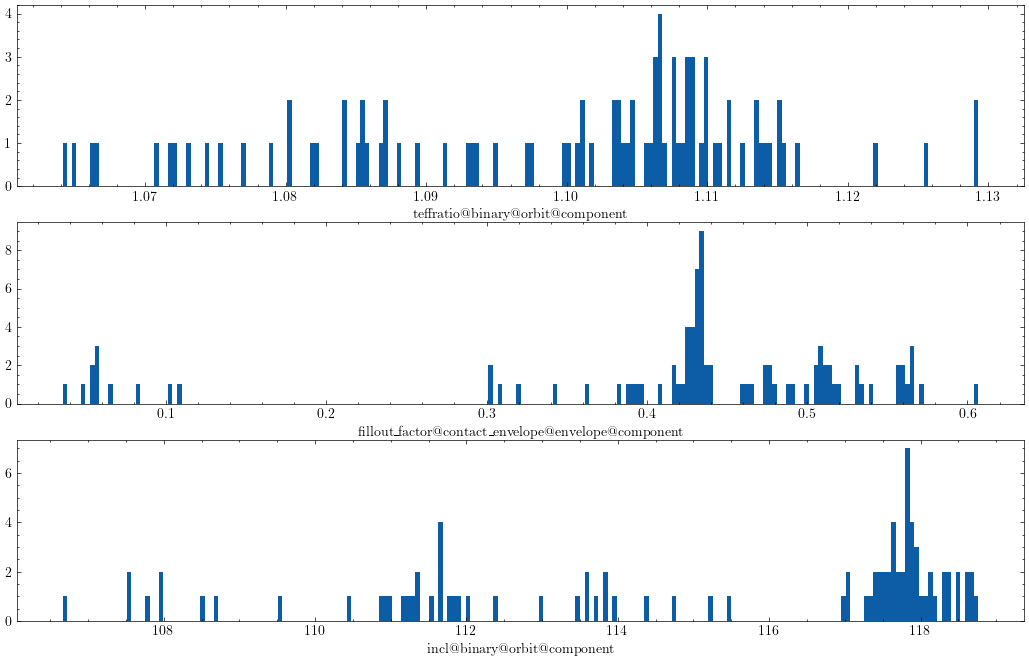

In [74]:
fig, axs = plt.subplots(nrows=3, figsize=(13, 8))
for i, (twig, vals) in enumerate(solutionVals.items()):
    ax = axs[i]
    ax.hist(vals, bins=200)
    ax.set_xlabel(twig)
plt.show()

In [75]:
phoebe.progressbars_off()
logger.setLevel(100) # no need to see temp errors from adopting solution

qChi2: dict[float, float] = {}

qSearchSolution = 'opt_q_search_solution'
for sfile in tqdm.tqdm(os.listdir("q-solutions/")):
    b.import_solution(os.path.join("q-solutions", sfile), overwrite=True)
    q = float(b.get_value(qualifier='comments', solution=qSearchSolution))
    b.set_value(qualifier='q', value=q)
    model = "q_search"
    if model not in b.models:
        opt_utils.adopt_solution(b, solution_name=qSearchSolution, compute_model_name=model, reset_params=True, print_sol=False)
        b.set_value(qualifier='comments', model=model, value=str(q))
    qChi2[q] = b.calculate_chi2(model, dataset=allDatasets)
    b.remove_model(model)

logger.setLevel(30) # default level
phoebe.progressbars_on()

100%|██████████| 91/91 [11:25<00:00,  7.53s/it]


In [76]:
best_q: float
bestChi2 = np.inf
for q, chi2 in qChi2.items():
    if chi2 < bestChi2:
        best_q = q
        bestChi2 = chi2
best_q, bestChi2

(0.3699999999999999, 11612.946879948266)

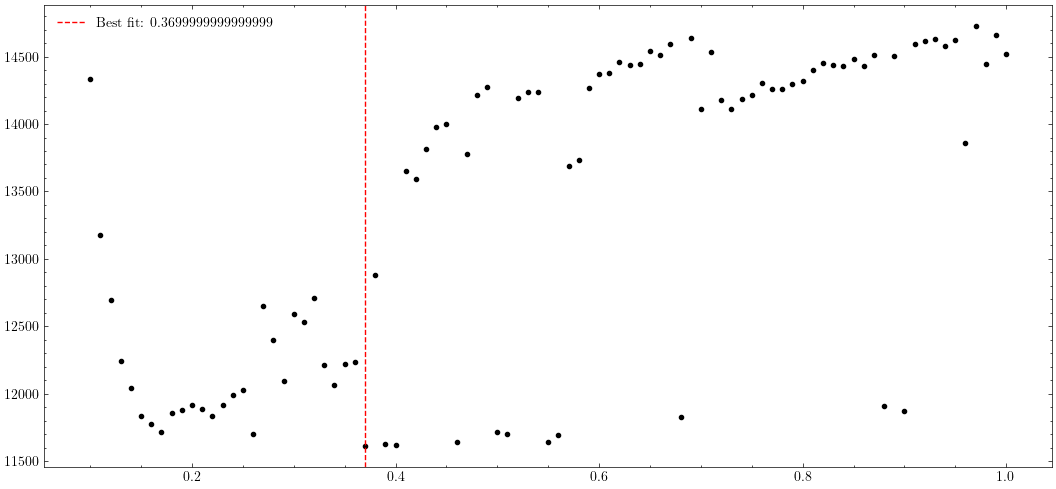

In [77]:
plt.figure(figsize=(13, 6))
plt.plot(qChi2.keys(), qChi2.values(), marker='.', color='black', linestyle='none')
plt.axvline(best_q, linestyle='--', color='r', label=f'Best fit: {best_q}')
plt.legend()
plt.show()

ParameterSet: 11 parameters
R  fitted_twigs@best_q_solutio...: ['teffratio@binary@orbit@component'
 'fillout_factor@contact_envelope@envelope@component'
 'incl@binary@orbit@component']
   adopt_parameters@best_q_sol...: ['teffratio@binary@orbit@component', 'fillout_factor@contact_envelope@envelope@component', 'incl@binary@orbit@component']
   adopt_distributions@best_q_...: False
   adopt_values@best_q_solutio...: True
R  message@best_q_solution@sol...: Optimization terminated successfully.
R  niter@best_q_solution@solution: 159
R  success@best_q_solution@sol...: True
R  initial_values@best_q_solut...: [1.0 0.6417897080770943 90.0]
R  fitted_values@best_q_soluti...: [1.07080220506589 0.10342730032321376 111.64653381522467]
R  fitted_units@best_q_solutio...: ['' '' 'deg']
   comments@best_q_solution@so...: 0.3699999999999999
Adopted:
teffratio@binary@orbit@component 1.07080  
fillout_factor@contact_envelope@envelope@component 0.10343  
incl@binary@orbit@component 111.64653 deg 

Origina

Wed, 19 Feb 2025 23:34 BUNDLE       ERROR   Constraint 'requiv@primary@star@constraint' raised the following error while attempting to solve for 'requiv@primary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@primary@star@component'] until the constraint succeeds.  Original error: potential < L2/L3 critical value
Wed, 19 Feb 2025 23:34 BUNDLE       ERROR   Constraint 'requiv@secondary@star@constraint' raised the following error while attempting to solve for 'requiv@secondary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@secondary@star@component'] until the constraint succeeds.  Original error: potential < L2/L3 critical value


  fillout_factor@contact_envelope@envelope@component 0.64179 
  incl@binary@orbit@component 90.00000 deg 


100%|██████████| 119/119 [00:06<00:00, 17.85it/s]


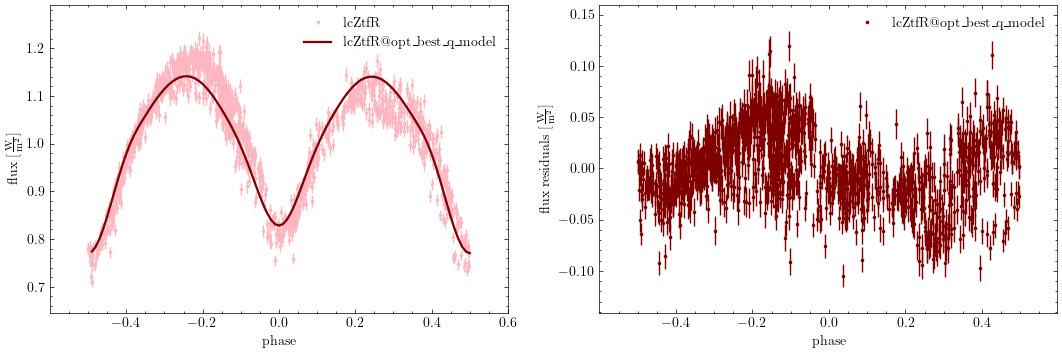

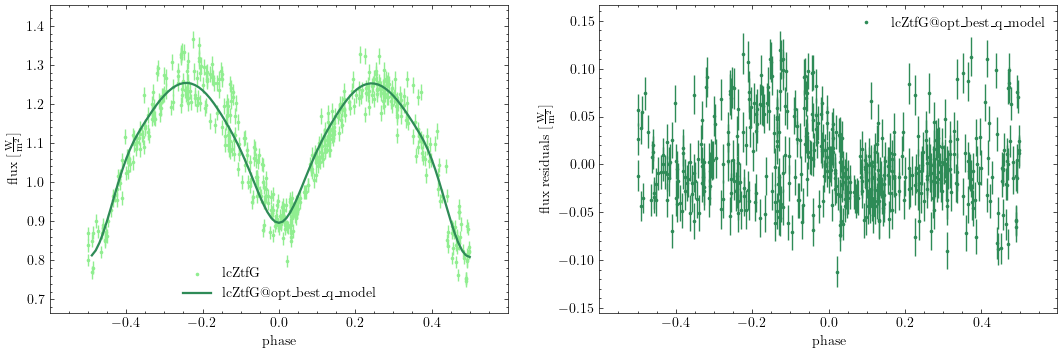

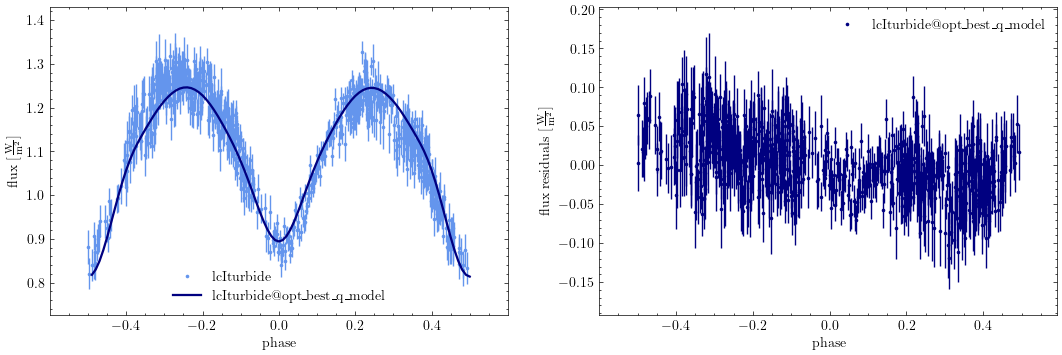

In [78]:
b.set_value(qualifier='q', value=best_q)
b.import_solution(f"./q-solutions/{best_q:.4f}.sol", solution='best_q_solution', overwrite=True)
print(b['best_q_solution'])
_, computeModelName = opt_utils.adopt_solution(b, solution_name='best_q_solution')
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 4), datasetGroups=allDatasets, model=computeModelName)

In [79]:
gen_utils.animateMesh(b, logger, model='opt_best_q_model')

<Figure size 800x600 with 0 Axes>

In [ ]:
gen_utils.saveBundle(b, "best-fit", subfolder="q-search")

## Fixed `incl`

Assuming totally eclipsing system, using only fixed inclination angles (optimizing `fillout_factor` and `teffratio`)

In [4]:
b = gen_utils.loadBundle("t0-default", subfolder="q-search")

In [14]:
print(b['ntriangles'])

Parameter: ntriangles@contact_envelope@phoebe01@compute
                       Qualifier: ntriangles
                     Description: Requested number of triangles (won't be exact).
                           Value: 3000
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: mesh_method:marching,hierarchy.is_meshable:true



In [19]:
b.set_value(qualifier='ntriangles', value=5250)

In [21]:
phoebe.progressbars_off()
logger.setLevel(100) # no need to see temp errors from adopting solution

inclChi2: dict[float, dict[float, float]] = {}
for d in os.listdir("./fixed-incl-q-search/"):
    incl = float(d.split('-')[-1])*u.degree
    b.set_value(qualifier='incl', component='binary', value=incl)

    qChi2: dict[float, float] = {}
    print(f"Finding chi2 using fixed incl={incl}")
    inclSolDirPath = os.path.join("fixed-incl-q-search", d, "q-solutions")
    for sfile in tqdm.tqdm(os.listdir(inclSolDirPath)):
        b.import_solution(os.path.join(inclSolDirPath, sfile), overwrite=True)
        q = float(b.get_value(qualifier='comments', solution='opt_q_search_solution'))
        if q in qChi2.keys():
            continue

        b.set_value(qualifier='q', value=q)
        model = "q_search"
        opt_utils.adopt_solution(b, solution_name='opt_q_search_solution', compute_model_name=model, reset_params=True, print_sol=False)
        if model in b.models:
            qChi2[q] = b.calculate_chi2(model, dataset=allDatasets)
            b.remove_model(model)
    inclChi2[incl.value] = qChi2

logger.setLevel(30)
phoebe.progressbars_on()

Finding chi2 using fixed incl=80.0 deg


  0%|          | 0/91 [00:00<?, ?it/s]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 26%|██▋       | 24/91 [09:31<21:59, 19.70s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 43%|████▎     | 39/91 [16:18<26:10, 30.20s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 52%|█████▏    | 47/91 [19:49<21:30, 29.33s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 62%|██████▏   | 56/91 [23:54<17:17, 29.64s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 69%|██████▉   | 63/91 [26:43<12:55, 27.70s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 85%|████████▍ | 77/91 [32:41<05:54, 25.35s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


100%|██████████| 91/91 [38:20<00:00, 25.28s/it]


Finding chi2 using fixed incl=85.0 deg


  0%|          | 0/91 [00:00<?, ?it/s]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 26%|██▋       | 24/91 [09:25<21:49, 19.54s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 52%|█████▏    | 47/91 [20:11<22:10, 30.25s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 55%|█████▍    | 50/91 [21:13<17:51, 26.14s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 62%|██████▏   | 56/91 [23:45<16:23, 28.10s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 69%|██████▉   | 63/91 [26:32<12:39, 27.12s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 75%|███████▍  | 68/91 [28:34<10:40, 27.84s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 85%|████████▍ | 77/91 [32:00<05:46, 24.73s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


100%|██████████| 91/91 [37:41<00:00, 24.85s/it]


Finding chi2 using fixed incl=90.0 deg


  0%|          | 0/91 [00:00<?, ?it/s]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 26%|██▋       | 24/91 [09:27<21:52, 19.59s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 43%|████▎     | 39/91 [16:15<26:01, 30.02s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 47%|████▋     | 43/91 [17:46<21:38, 27.06s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 52%|█████▏    | 47/91 [19:15<18:59, 25.91s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 55%|█████▍    | 50/91 [20:16<16:39, 24.39s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 69%|██████▉   | 63/91 [26:05<13:14, 28.38s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 75%|███████▍  | 68/91 [28:06<10:45, 28.05s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 85%|████████▍ | 77/91 [31:35<05:52, 25.15s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


100%|██████████| 91/91 [37:16<00:00, 24.58s/it]


Finding chi2 using fixed incl=95.0 deg


  0%|          | 0/91 [00:00<?, ?it/s]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 26%|██▋       | 24/91 [09:28<21:52, 19.59s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 43%|████▎     | 39/91 [16:16<26:05, 30.11s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 52%|█████▏    | 47/91 [19:47<21:34, 29.43s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 55%|█████▍    | 50/91 [20:48<17:33, 25.69s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 62%|██████▏   | 56/91 [23:21<16:27, 28.20s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 69%|██████▉   | 63/91 [26:10<12:43, 27.26s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 75%|███████▍  | 68/91 [28:11<10:35, 27.64s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 85%|████████▍ | 77/91 [31:36<05:46, 24.76s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


100%|██████████| 91/91 [37:14<00:00, 24.56s/it]


Finding chi2 using fixed incl=100.0 deg


  0%|          | 0/91 [00:00<?, ?it/s]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 26%|██▋       | 24/91 [09:25<21:53, 19.61s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 43%|████▎     | 39/91 [16:11<25:37, 29.57s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 52%|█████▏    | 47/91 [19:44<21:39, 29.53s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 62%|██████▏   | 56/91 [23:49<17:14, 29.57s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 69%|██████▉   | 63/91 [26:37<12:44, 27.31s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


 85%|████████▍ | 77/91 [32:35<05:55, 25.39s/it]

Ran into exception Mesh failed or incomplete. Try increasing the number of triangles (ntriangles)!


100%|██████████| 91/91 [38:14<00:00, 25.21s/it]


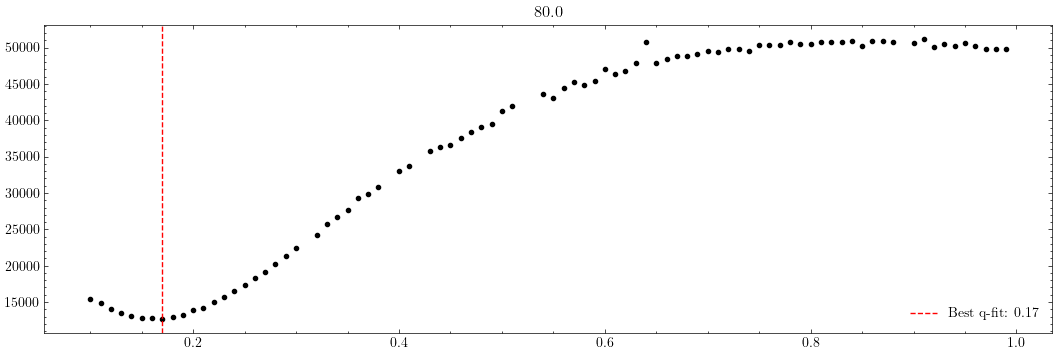

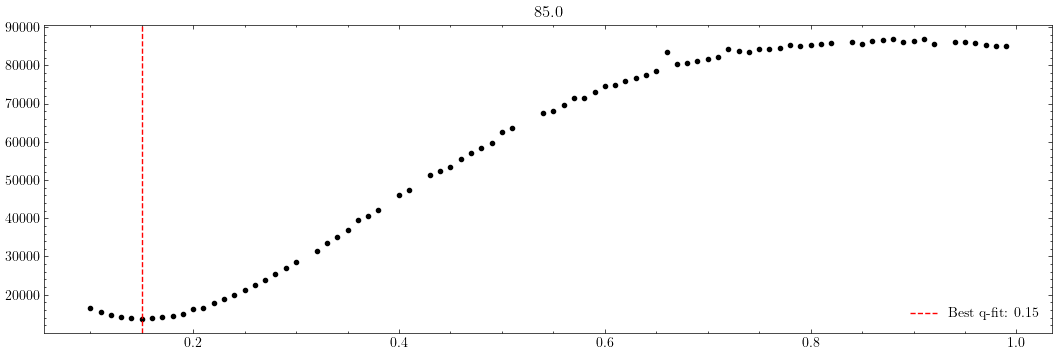

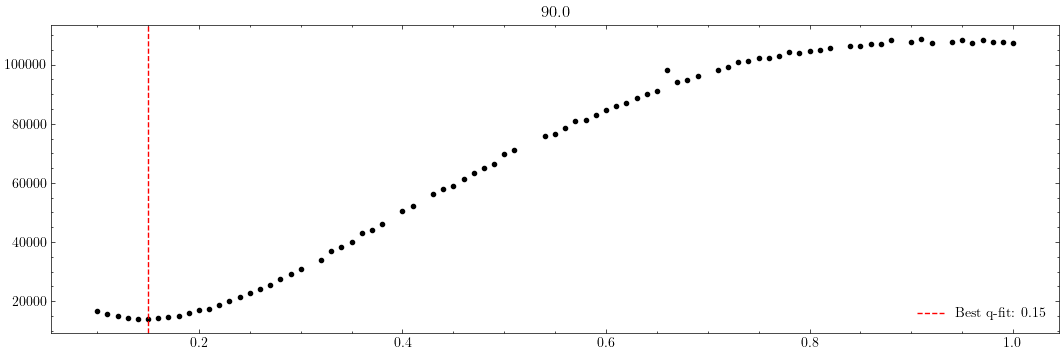

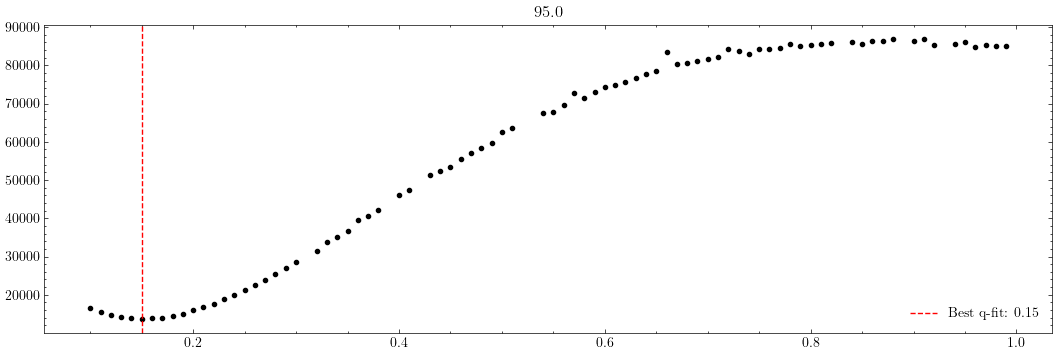

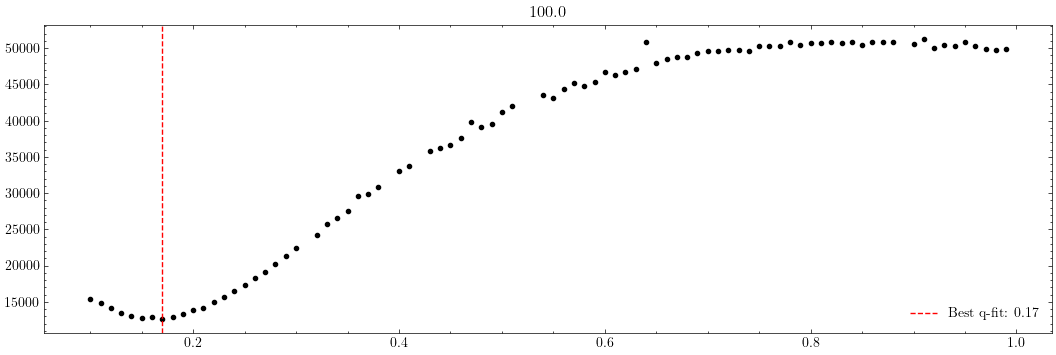

In [28]:
min_incl_q: dict[float, float] = {}
for incl, qChi2 in inclChi2.items():
    incl_q = list(qChi2.keys())
    incl_chi2 = list(qChi2.values())
    min_incl_q[incl] = incl_q[np.argmin(incl_chi2)]

    plt.figure(figsize=(13, 4))
    plt.scatter(qChi2.keys(), qChi2.values(), marker='.', color='black')
    plt.axvline(min_incl_q[incl], linestyle='dashed', color='r', label=f"Best q-fit: {min_incl_q[incl]:.2f}")
    plt.title(incl)
    plt.legend()
plt.show()

Adopted:
teffratio@binary@orbit@component 1.06066  
fillout_factor@contact_envelope@envelope@component 0.05728  

Original values:
  teffratio@binary@orbit@component 1.06066 


Sat, 22 Feb 2025 22:24 BUNDLE       ERROR   Constraint 'requiv@primary@star@constraint' raised the following error while attempting to solve for 'requiv@primary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@primary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value
Sat, 22 Feb 2025 22:24 BUNDLE       ERROR   Constraint 'requiv@secondary@star@constraint' raised the following error while attempting to solve for 'requiv@secondary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@secondary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value


  fillout_factor@contact_envelope@envelope@component 0.05728 


100%|██████████| 119/119 [00:14<00:00,  8.17it/s]


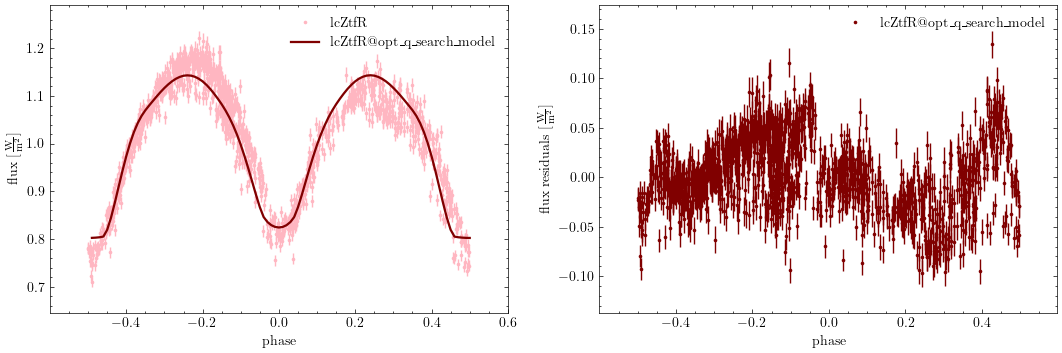

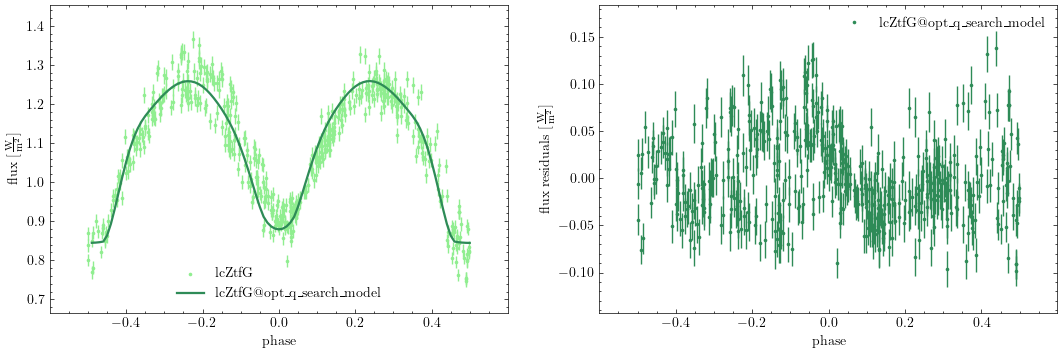

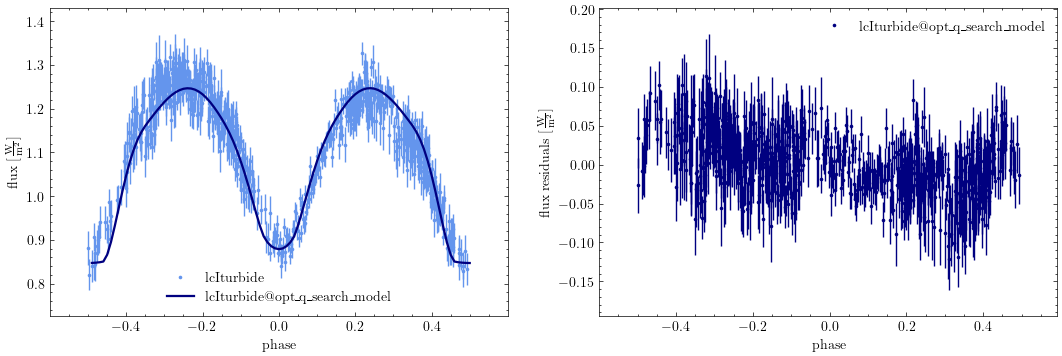

In [36]:
bestQSearchSolutionPath = "./fixed-incl-q-search/q-search-incl-100.0/q-solutions/0.1700.sol"

b.set_value(qualifier='incl', component='binary', value=100*u.degree)
b.set_value(qualifier='q', value=0.17)
_, computeModelName = opt_utils.adopt_solution(b, solution_file=bestQSearchSolutionPath)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 4), datasetGroups=allDatasets, model=computeModelName)

In [39]:
gen_utils.animateMesh(b, logger, model=computeModelName)

<Figure size 800x600 with 0 Axes>

### Parameter optimization

One last run of NMS to try to get better $\chi^2$

In [40]:
opt_utils.optimize_params(b, fit_twigs=['q', 'incl@binary', 'teffratio', 'fillout_factor'], label='q_search_followup', export=True, datasets=allDatasets, maxiter=250)

External Solver: ./external-jobs/optimizer.nelder_mead_opt_q_search_followup.py ./results/opt_q_search_followup_solution


('opt_q_search_followup', 'opt_q_search_followup_solution')

Adopted:
q@binary@orbit@component 0.18859  
incl@binary@orbit@component 105.96077 deg 
teffratio@binary@orbit@component 1.06658  
fillout_factor@contact_envelope@envelope@component 0.05548  

Original values:
  q@binary@orbit@component 0.17000 
  incl@binary@orbit@component 100.00000 deg 
  teffratio@binary@orbit@component 1.06066 
  fillout_factor@contact_envelope@envelope@component 0.05728 


100%|██████████| 119/119 [00:16<00:00,  7.09it/s]


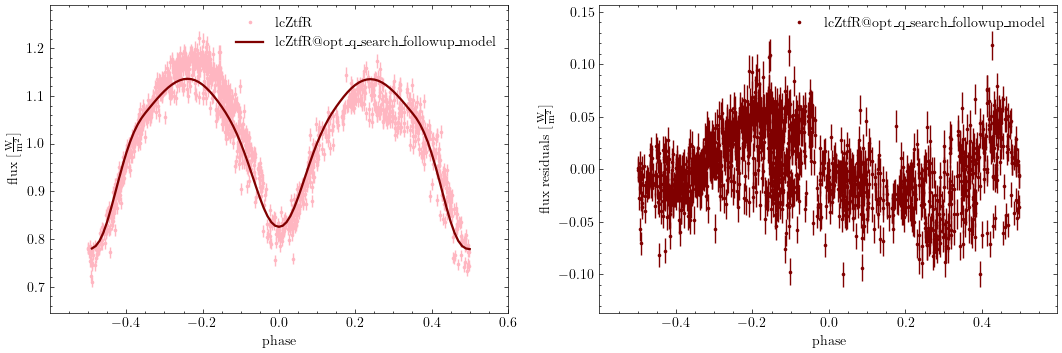

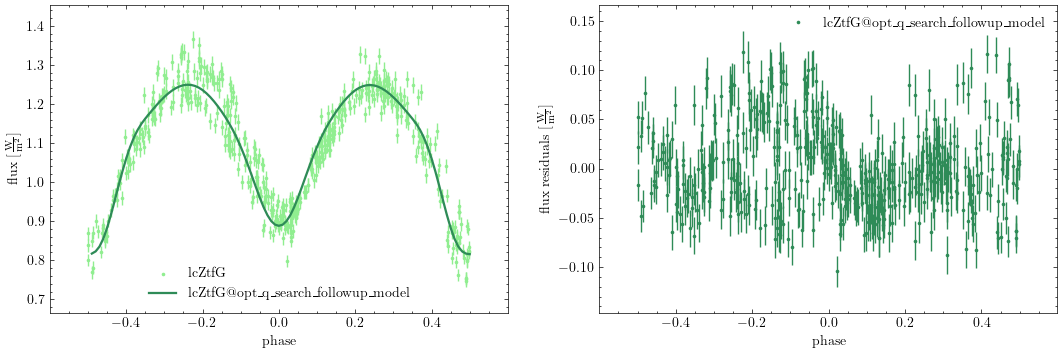

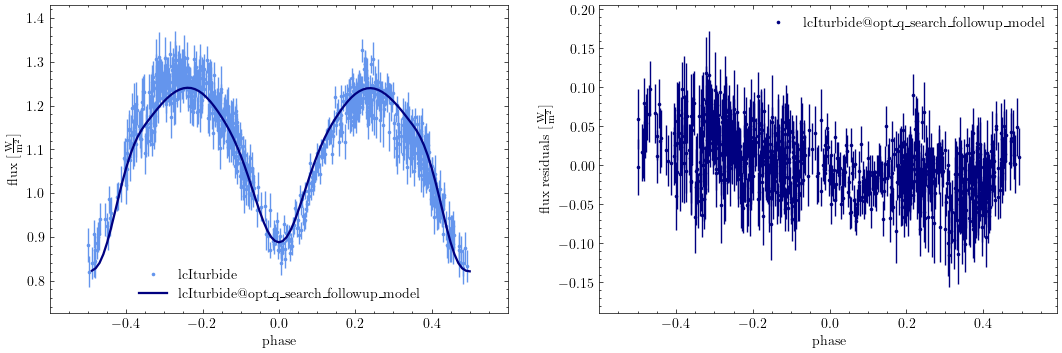

latest
	 Iturbide (Norm) - 1282.2573248045776
------------------------------------------------
	 ZTF - 11400.282735841258
		 lcZtfR - 8539.064182236736
		 lcZtfG - 2861.218553604521
opt_q_search_model
	 Iturbide (Norm) - 1282.2573248045776
------------------------------------------------
	 ZTF - 11400.282735841258
		 lcZtfR - 8539.064182236736
		 lcZtfG - 2861.218553604521
opt_q_search_followup_model
	 Iturbide (Norm) - 1316.992233209527
------------------------------------------------
	 ZTF - 10265.449170379823
		 lcZtfR - 7675.674641935175
		 lcZtfG - 2589.7745284446473


In [43]:
_, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/results/opt_q_search_followup_solution")
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 4), datasetGroups=allDatasets, model=computeModelName)
gen_utils.printAllModelsChi2(b)

In [45]:
gen_utils.saveBundle(b, "best-fit", subfolder="q-search")

Sun, 23 Feb 2025 00:02 PARAMETERS   WARNING for faster compact saving, install ujson


'bundle-saves/q-search/best-fit.json.gz'

# Stellar spots

Accounting for O'Connell effect

## Bright spot

In [3]:
b = gen_utils.loadBundle("best-fit", subfolder="q-search")
b.set_value(qualifier='compute_phases', dataset='mesh01', value=phoebe.linspace(0, 1, 21))

In [4]:
b.run_compute(model='opt_q_search_followup_model', overwrite=True)

100%|██████████| 104/104 [00:15<00:00,  6.76it/s]


<ParameterSet: 222 parameters | kinds: mesh, lc>

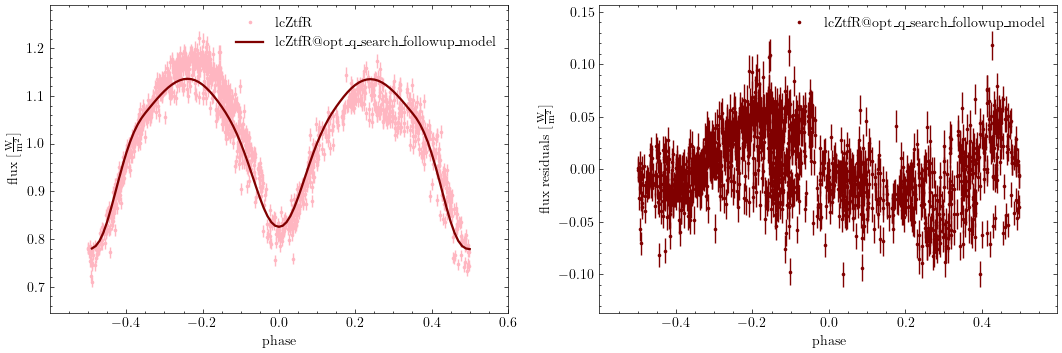

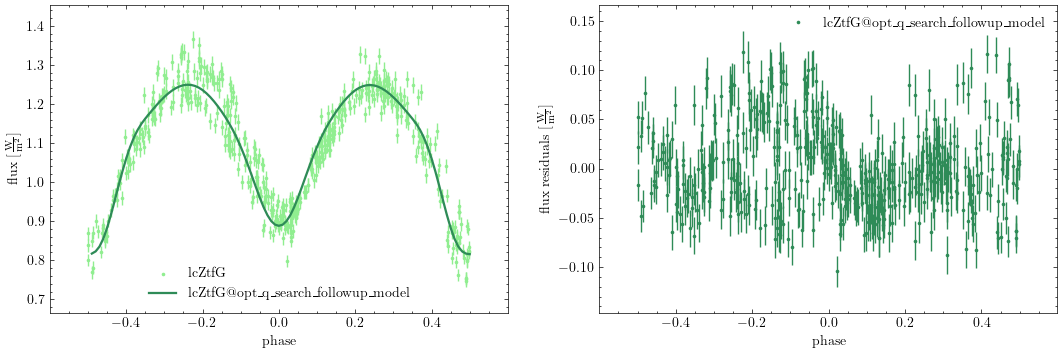

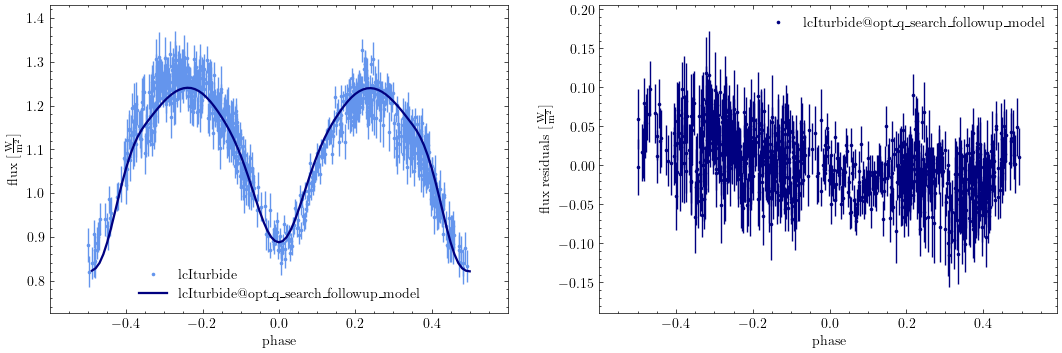

Thu, 27 Feb 2025 16:05 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.220986, assuming named color
Thu, 27 Feb 2025 16:05 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.220986, assuming named color


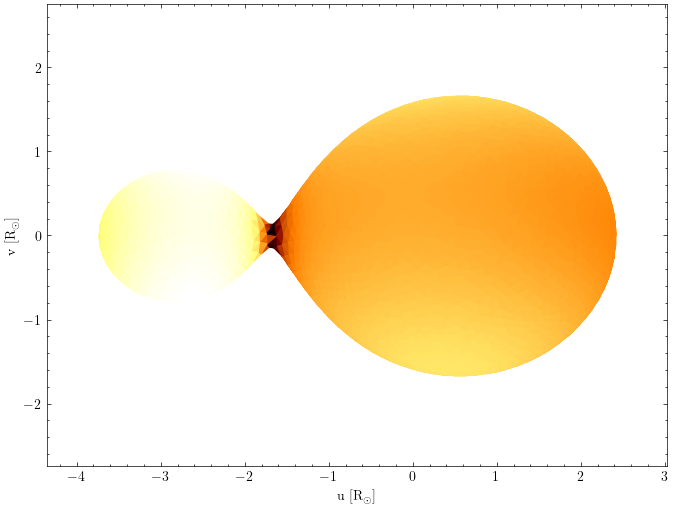

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [5]:
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 4), datasetGroups=allDatasets, model='opt_q_search_followup_model')
b.plot(phase=0.75, show=True, dataset='mesh01', model='opt_q_search_followup_model', fc='teffs', ec='face')

100%|██████████| 104/104 [00:14<00:00,  7.00it/s]


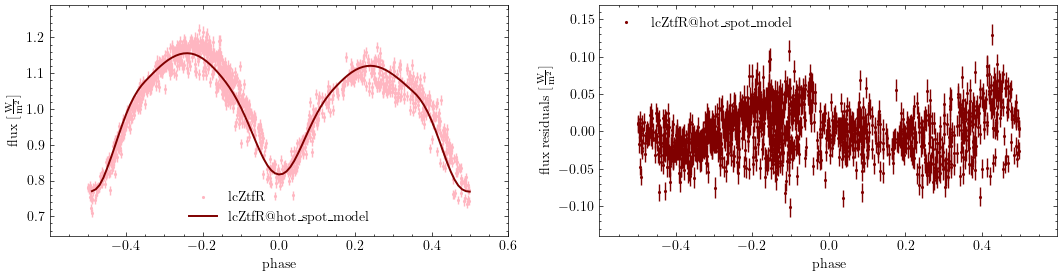

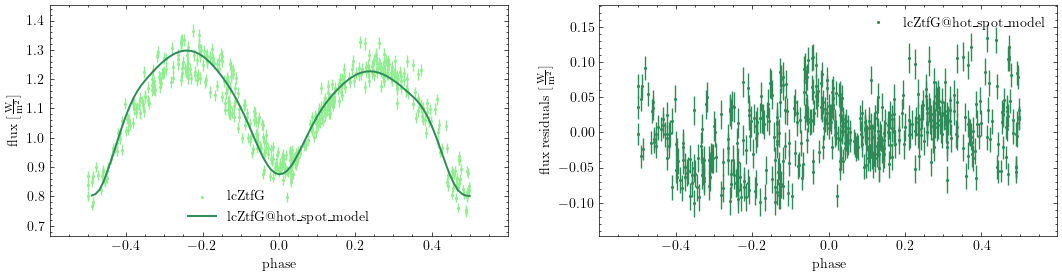

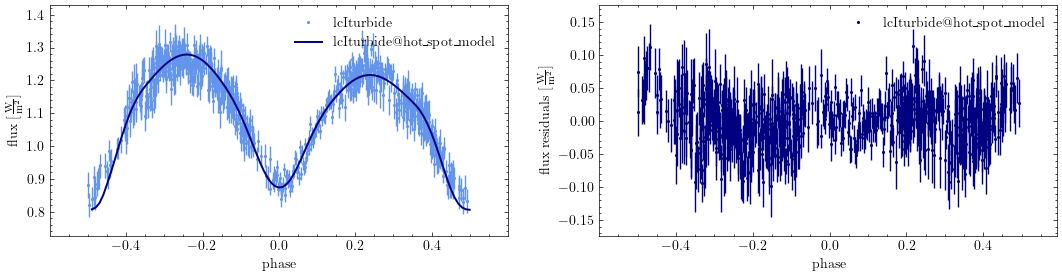

Thu, 27 Feb 2025 16:06 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.220986, assuming named color
Thu, 27 Feb 2025 16:06 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.220986, assuming named color


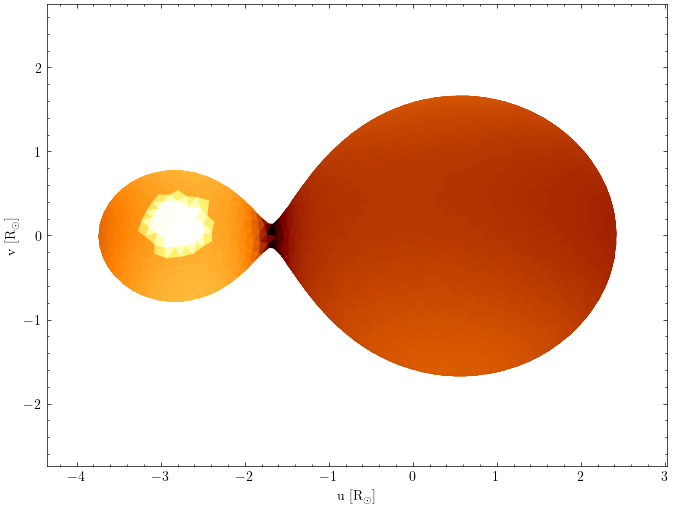

opt_q_search_followup_model
	 Iturbide (Norm) - 1316.992233209527
------------------------------------------------
	 ZTF - 10265.449170379823
		 lcZtfR - 7675.674641935175
		 lcZtfG - 2589.7745284446473
hot_spot_model
	 Iturbide (Norm) - 1148.4979219850977
------------------------------------------------
	 ZTF - 9601.698307272589
		 lcZtfR - 6660.953748762627
		 lcZtfG - 2940.744558509962


In [6]:
b.remove_features_all()
b.add_spot(component='secondary', feature='secondary_hot_spot', 
            relteff=1.15, 
            radius=25,
            colat=85,
            long=-90)
b.run_compute(model='hot_spot_model', overwrite=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 3), datasetGroups=allDatasets, model='hot_spot_model')
b.plot(phase=0.75, kind='mesh', show=True, fc='teffs', ec='face', model='hot_spot_model')
gen_utils.printModelsChi2(b, ['opt_q_search_followup_model', 'hot_spot_model'])

In [7]:
print(b['secondary_hot_spot'])

ParameterSet: 5 parameters
   colat@secondary_hot_spot@fe...: 85.0 deg
   long@secondary_hot_spot@fea...: 270.0 deg
   radius@secondary_hot_spot@f...: 25.0 deg
   relteff@secondary_hot_spot@...: 1.15
   enabled@secondary_hot_spot@...: True


In [8]:
opt_utils.optimize_params(b, label='secondary_hot_spot', export=True, datasets=allDatasets, maxiter=250,
                            fit_twigs=['colat@secondary_hot_spot', 'long@secondary_hot_spot', 'radius@secondary_hot_spot', 'relteff@secondary_hot_spot'])

External Solver: ./external-jobs/optimizer.nelder_mead_opt_secondary_hot_spot.py ./results/opt_secondary_hot_spot_solution


('opt_secondary_hot_spot', 'opt_secondary_hot_spot_solution')

Thu, 27 Feb 2025 16:06 BUNDLE       WARNING not all uniqueids in fitted_uniqueids@opt_secondary_hot_spot_solution@solution are still valid.  Falling back on twigs.  Save and load same bundle to prevent this extra cost.


Adopted:
colat@secondary_hot_spot@secondary@spot@feature 93.50569 deg 
long@secondary_hot_spot@secondary@spot@feature 242.04078 deg 
radius@secondary_hot_spot@secondary@spot@feature 25.86795 deg 
relteff@secondary_hot_spot@secondary@spot@feature 1.12025  

Original values:
  colat@secondary_hot_spot@secondary@spot@feature 85.00000 deg 
  long@secondary_hot_spot@secondary@spot@feature 270.00000 deg 
  radius@secondary_hot_spot@secondary@spot@feature 25.00000 deg 
  relteff@secondary_hot_spot@secondary@spot@feature 1.15000 


100%|██████████| 104/104 [00:15<00:00,  6.93it/s]


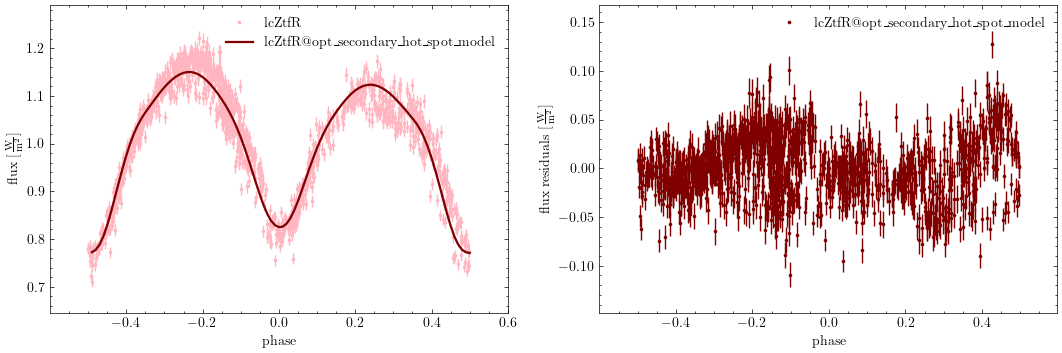

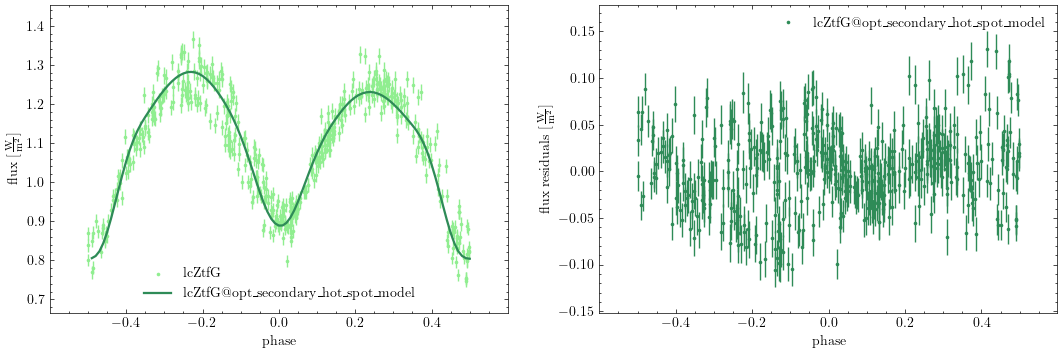

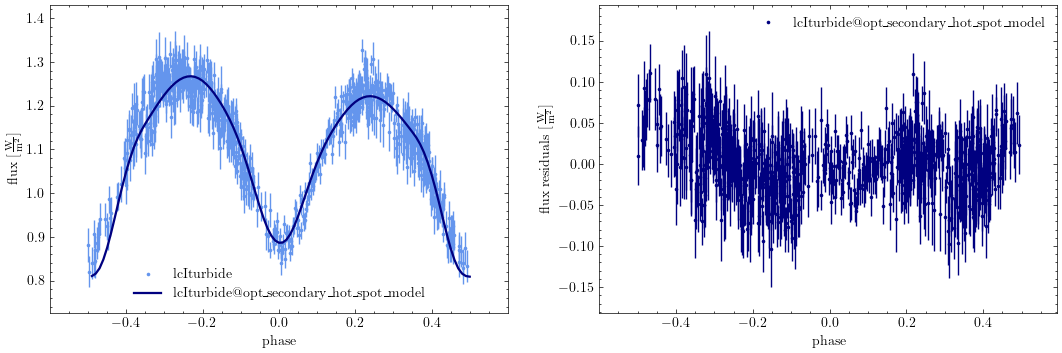

Thu, 27 Feb 2025 16:06 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.220986, assuming named color
Thu, 27 Feb 2025 16:06 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.220986, assuming named color


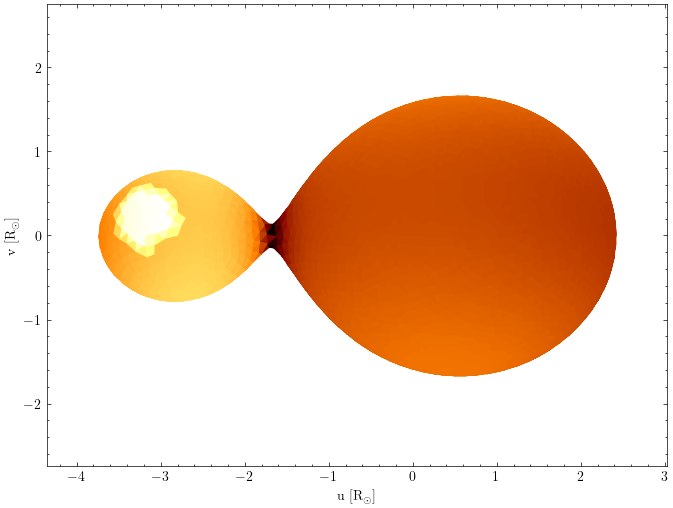

hot_spot_model
	 Iturbide (Norm) - 1148.4979219850977
------------------------------------------------
	 ZTF - 9601.698307272589
		 lcZtfR - 6660.953748762627
		 lcZtfG - 2940.744558509962
opt_secondary_hot_spot_model
	 Iturbide (Norm) - 1210.104512088794
------------------------------------------------
	 ZTF - 8819.73291197999
		 lcZtfR - 6272.406754451431
		 lcZtfG - 2547.3261575285596


In [9]:
_, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/results/opt_secondary_hot_spot_solution")
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 4), datasetGroups=allDatasets, model=computeModelName)
b.plot(phase=0.75, kind='mesh', show=True, fc='teffs', ec='face', model=computeModelName)
gen_utils.printModelsChi2(b, ['hot_spot_model', computeModelName])

## Cold spot

100%|██████████| 104/104 [00:14<00:00,  7.06it/s]


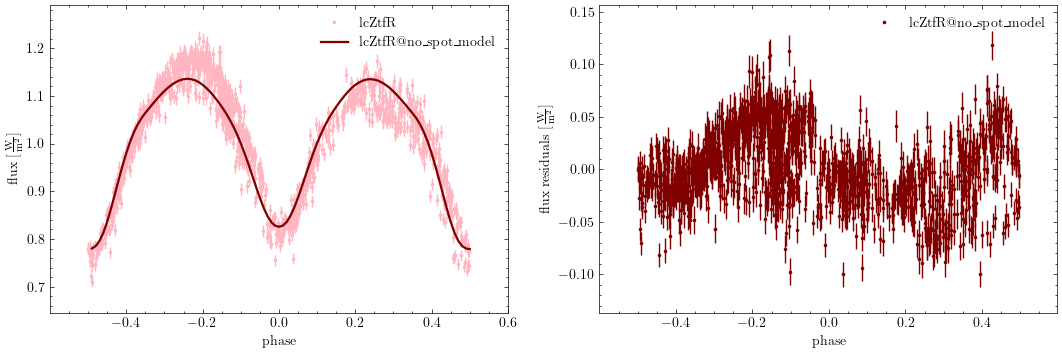

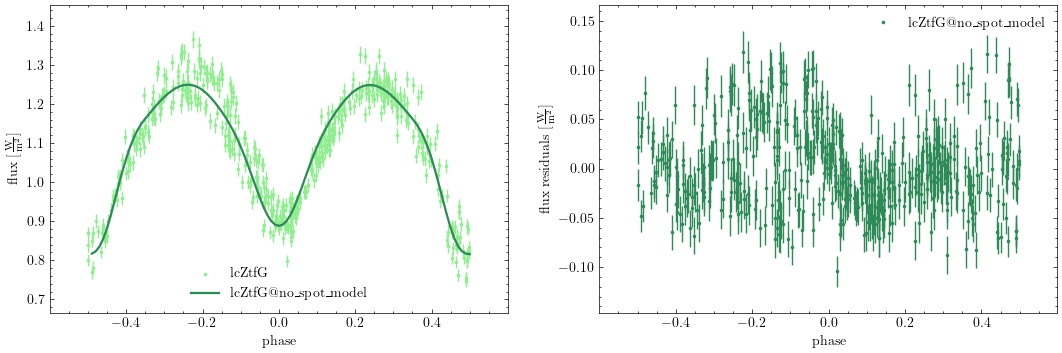

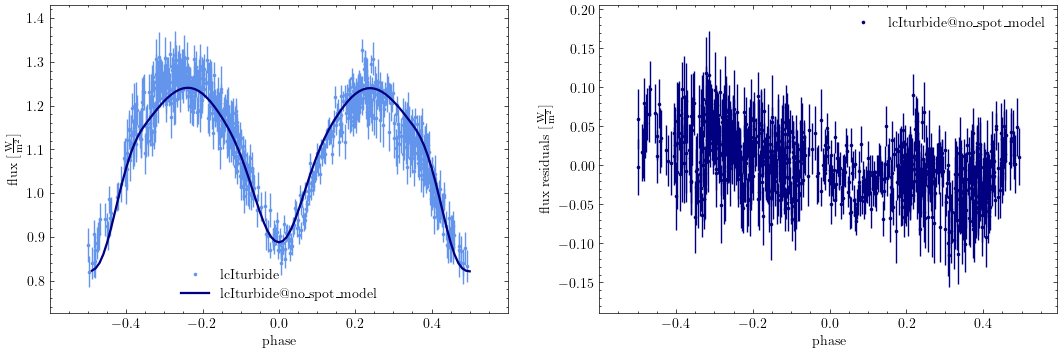

Thu, 27 Feb 2025 16:06 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.220986, assuming named color
Thu, 27 Feb 2025 16:06 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.220986, assuming named color


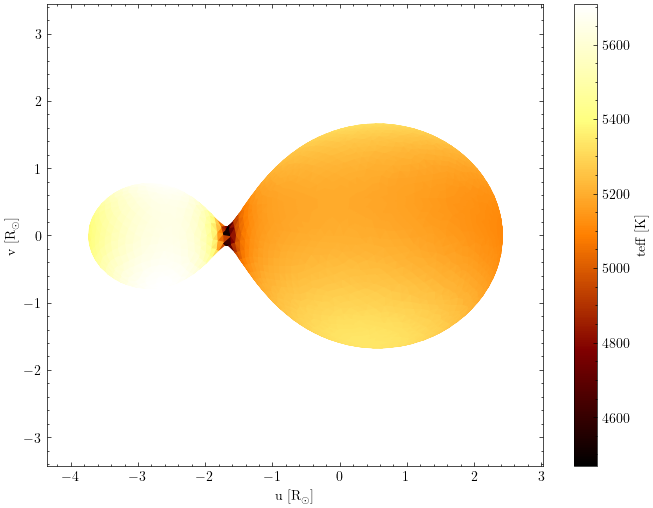

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 800x600 with 2 Axes>)

In [10]:
b.disable_feature('secondary_hot_spot')
b.run_compute(model='no_spot_model', overwrite=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 4), datasetGroups=allDatasets, model='no_spot_model')
b.plot(kind='mesh', model='no_spot_model', show=True, fc='teffs', ec='face', phase=0.75, draw_sidebars=True)

In [11]:
print(b['lcIturbide@passband'])

Parameter: passband@lcIturbide@dataset
                       Qualifier: passband
                     Description: Passband
                           Value: Gaia:BP
                         Choices: Walraven:V, Ultracam:gs, Ultracam:zs, BRITE:blue, Bolometric:900-40000, Cousins:R, SDSS:rprime, Gaia:RP, Gaia:G, Hipparcos:Hp, ZTF:i_filter, Johnson:H, Ultracam:is, Walraven:L, ZTF:r, SMEI:white, LSST:r, Johnson:J, LSST:g, Pan-Starrs:r, Pan-Starrs:w, Stromgren:u, LSST:i, SuperWASP:post2004, KELT:R, SDSS:uprime, Johnson:V, LSST:y, Walraven:U, SDSS:gprime, Walraven:B, TESS:T, Johnson:U, LSST:u, Pan-Starrs:i, Ultracam:rs, Pan-Starrs:open, ZTF:g_filter, SDSS:u, SDSS:i, SuperWASP:pre2004, ZTF:i, ZTF:r_filter, SDSS:z, Pan-Starrs:g, SDSS:iprime, Johnson:R, Cousins:I, Johnson:K, SDSS:zprime, ZTF:g, Stromgren:b, Gaia:BP, Ultracam:us, SDSS:g, Kepler:mean, Gaia:RVS, Pan-Starrs:y, Tycho:B, SDSS:r, Stromgren:y, LSST:z, Walraven:W, BRITE:red, Tycho:V, Pan-Starrs:z, Stromgren:v, Johnson:I, Johnson:B
   

In [12]:
b.set_value(qualifier='passband', dataset=iturbideDataset, value='Johnson:V')

100%|██████████| 104/104 [00:14<00:00,  7.04it/s]


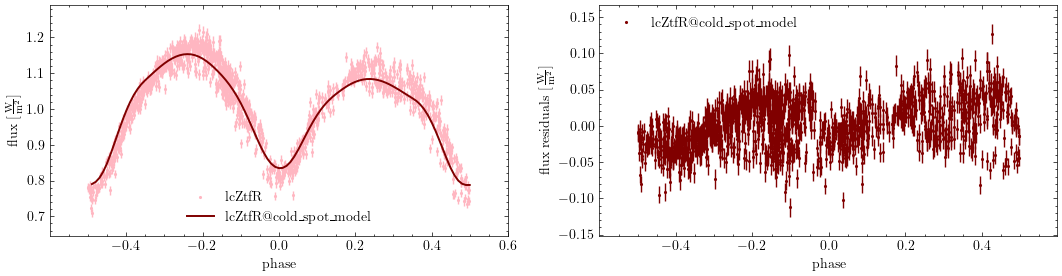

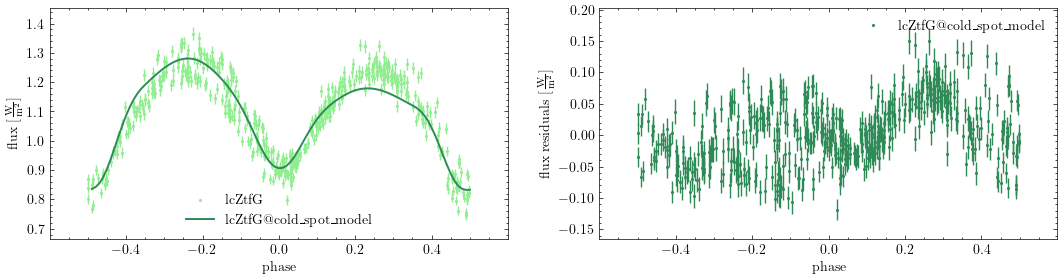

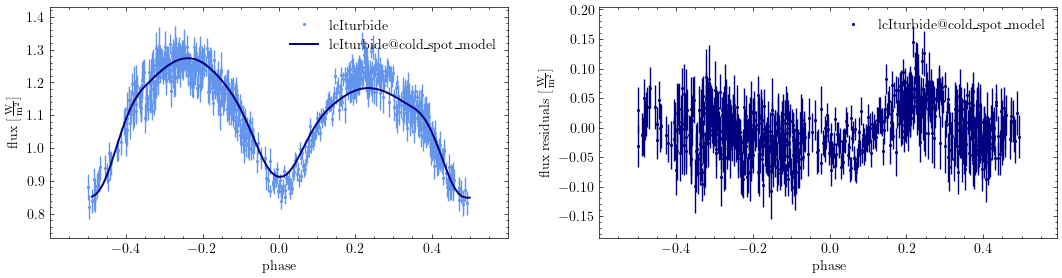

Thu, 27 Feb 2025 16:07 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.054203, assuming named color
Thu, 27 Feb 2025 16:07 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.054203, assuming named color


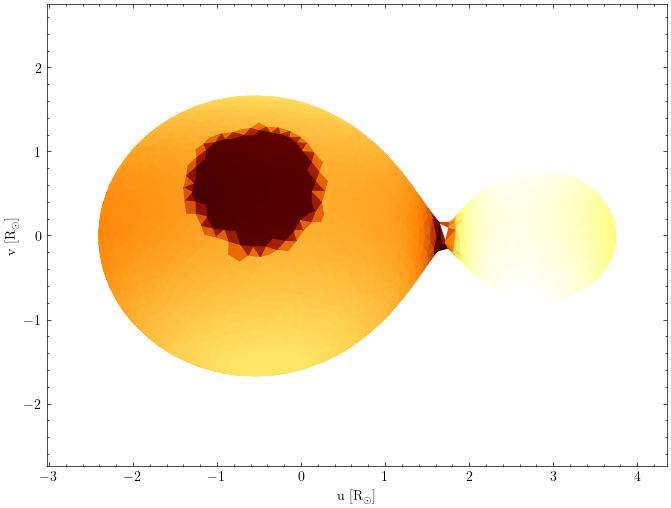

opt_q_search_followup_model
	 Iturbide (Norm) - 1316.992233209527
------------------------------------------------
	 ZTF - 10265.449170379823
		 lcZtfR - 7675.674641935175
		 lcZtfG - 2589.7745284446473
hot_spot_model
	 Iturbide (Norm) - 1148.4979219850977
------------------------------------------------
	 ZTF - 9601.698307272589
		 lcZtfR - 6660.953748762627
		 lcZtfG - 2940.744558509962
cold_spot_model
	 Iturbide (Norm) - 1773.9403200434858
------------------------------------------------
	 ZTF - 10526.357274638038
		 lcZtfR - 7134.04863724685
		 lcZtfG - 3392.3086373911883


In [13]:
b.add_spot(component='primary', feature='primary_cold_spot', overwrite=True,
            relteff=0.9, 
            radius=25,
            colat=85,
            long=-90)
b.run_compute(model='cold_spot_model', overwrite=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 3), datasetGroups=allDatasets, model='cold_spot_model')
b.plot(phase=0.25, kind='mesh', show=True, fc='teffs', ec='face', model='cold_spot_model')
gen_utils.printModelsChi2(b, ['opt_q_search_followup_model', 'hot_spot_model', 'cold_spot_model'])

In [14]:
opt_utils.optimize_params(b, label='primary_cold_spot', export=True, datasets=allDatasets, maxiter=250,
                            fit_twigs=['colat@primary_cold_spot', 'long@primary_cold_spot', 'radius@primary_cold_spot', 'relteff@primary_cold_spot'])

External Solver: ./external-jobs/optimizer.nelder_mead_opt_primary_cold_spot.py ./results/opt_primary_cold_spot_solution


('opt_primary_cold_spot', 'opt_primary_cold_spot_solution')